In [1]:
import numpy as np
import pandas as pd
import os
import sys
import mne
np.random.seed(123456789)
sys.path.append('../../../')
from tvb.simulator.lab import *
import tvbsim

# to run simulation and post processing and data loading
from tvbsim.postprocess.postprocess import PostProcessor
from tvbsim.postprocess.detectonsetoffset import DetectShift
from tvbsim.maintvbexp import MainTVBSim
from tvbsim.io.patient.subject import Subject
from tvbsim.io.simdata.loadtvbdata import StructuralDataLoader
from tvbsim.io.loadsimdataset import LoadSimDataset
from tvbsim.base.constants.config import Config

from tvbsim.visualize.old import plotts
sys.path.append('../../../bintng/util/')
from run_freq import FreqAnalysis
from tvbsim.execute.cluster.hpc_tvbsimmodel import SimVsRealModel
from tvbsim.execute.cluster.hpc_tvbsimmodel import TVBSimModel

# import basic plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# configuration and plotting
config = Config() 
config.figures.MATPLOTLIB_BACKEND="qt5" #"Qt4Agg" #"inline"
config.figures.SHOW_FLAG=True

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext line_profiler
%load_ext memory_profiler
%matplotlib inline
%load_ext autoreload
%autoreload 2

   INFO  log level set to INFO


In [2]:
def load_raw_data(patdatadir, datafile, metadatadir, patient, reference):
    loader = LoadSimDataset(root_dir=patdatadir, 
                                datafile=datafile, 
                                rawdatadir=metadatadir, 
                                patient=patient,
                                reference=reference, 
                                preload=True)
    # get filtered/referenced rawdata
    epits = loader.epits
    rawdata = loader.rawdata 
    metadata = loader.getmetadata()

    return epits, rawdata, metadata

def load_real_data(patient, rawdatadir, idatafile, type_recording='sz', reference='monopolar'):
    # if we are clipping the datasets:
    loader = Subject(name=patient,
                    root_dir=rawdatadir,
                    preload=True,
                    SIM=False)
    seiz_recordings = loader.seizure_recordings
    ii_recordings = loader.interictal_recordings
    print("These are our seizure recordings!: ", loader.seizure_recordings)
    print("These are our interictal recordings!: ", loader.interictal_recordings)
#     if type_recording == 'sz':
#         idatafile = [idx for idx, name in enumerate(loader.seizure_files) if datafile in name]
#     elif type_recording == 'ii':
#         idatafile = [idx for idx, name in enumerate(loader.interictal_files) if datafile in name]
#     assert len(idatafile) == 1
#     idatafile = idatafile[0]

    # extract raw and metadata
    rawdata, metadata = loader.load_dataset(idatafile,  
                                            reference=reference, 
                                            sync=True)
    print(rawdata.shape)
    print(metadata.keys())
    return rawdata, metadata

In [3]:
patient = 'id001_bt'

In [4]:
from tvbsim.exp.master import MasterExp

root_dir = os.path.join('/Users/adam2392/Downloads/tngpipeline/', patient)
loader = StructuralDataLoader(root_dir = root_dir)

## OUTPUTFILE NAME ##
outputdatadir = '~/Downloads/simexp/'
if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)
    
i = 0
outputfilename = os.path.join(outputdatadir,
            '{}_{}.npz'.format(patient, i))
metafilename = os.path.join(outputdatadir,
            '{}_{}.json'.format(patient, i))


# load in the data to run frequency analysis
reference = 'monopolar'
patdatadir = outputdatadir
metadatadir = root_dir
datafile = outputfilename
epits, seegts, metadata = load_raw_data(patdatadir, datafile, metadatadir, patient, reference)

2018-06-20 16:48:10,276 - DEBUG - StructuralDataLoader - 
Already renamed seeg.xyz possibly!

2018-06-20 16:48:10,277 - DEBUG - StructuralDataLoader - 
Already renamed gaininv.mat possibly!

2018-06-20 16:48:10,279 - INFO - tvbsim.io.readers.read_connectivity - Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
2018-06-20 16:48:10,300 - INFO - tvbsim.io.readers.read_connectivity - Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
NOT USING SUBCORT
2018-06-20 16:48:22,621 - DEBUG - StructuralDataLoader - 
Loaded in seeg xyz coords!

2018-06-20 16:48:28,218 - DEBUG - StructuralDataLoader - 
Mapped contacts to regions!

2018-06-20 16:48:28,228 - 

In [5]:
idatafile = 0
rawdata, metadata = load_real_data(patient, root_dir, idatafile, 
                                   type_recording='sz', reference='monopolar')
print(rawdata.shape)
print(metadata.keys())


2018-06-20 16:48:34,483 - DEBUG - Subject - 
Already renamed seeg.xyz possibly!

2018-06-20 16:48:34,485 - INFO - tvbsim.io.readers.read_connectivity - Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
2018-06-20 16:48:34,508 - INFO - tvbsim.io.readers.read_connectivity - Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
2018-06-20 16:48:34,528 - INFO - Subject - 
Loaded in ez hypothesis!

   INFO  
Loaded in ez hypothesis!

2018-06-20 16:48:50,623 - DEBUG - Subject - 
Loaded in seeg xyz coords!

2018-06-20 16:48:55,312 - DEBUG - Subject - 
Mapped contacts to regions!

reading fif
reading fif
reading fif
reading fif
reading fif
('These are ou

In [6]:
print(metadata['rawfilename'])

/Users/adam2392/Downloads/tngpipeline/id001_bt/seeg/fif/BTcrisepartielle+preictalspiking_0009.raw.fif


# Compute PSD And Bin Them

In [7]:
def binfreqvalues(power, freqs, freqbands):
    power = np.abs(power)
    # Create an empty array
    power_binned = np.zeros(shape=(power.shape[0],
                                   len(freqbands),
                                   power.shape[2]))
    
    for idx, (name, freqband) in enumerate(sorted(freqbands.items())):
        print(name, freqband)
        # compute the freq indices for each band
        freqbandindices = _computefreqindices(freqs, freqband)
        
        # Create an empty array = C x T (frequency axis is compresssed into 1 band)
        # average between these two indices
        power_binned[:, idx, :] = np.mean(
            power[:, freqbandindices[0]:freqbandindices[1] + 1, :], axis=1)
    return power_binned
def _computefreqindices(reqs, freqband):
    """
    Compute the frequency indices for this frequency band

    freqs = list of frequencies
    freqband = [lowerbound, upperbound] frequencies of the 
            frequency band
    """
    for freq in freqband:
        lowerband = freqband[0]
        upperband = freqband[1]

        # get indices where the freq bands are put in
        freqbandindices = np.where(
            (freqs >= lowerband) & (freqs < upperband))
        freqbandindices = [freqbandindices[0][0], freqbandindices[0][-1]]
    return freqbandindices

Number of frequencies: 251
Number of time steps: 3068
500
250
(97, 251, 3068)
4.834194989537313
-7.045629140895583
CPU times: user 28.5 s, sys: 1.77 s, total: 30.2 s
Wall time: 30.5 s


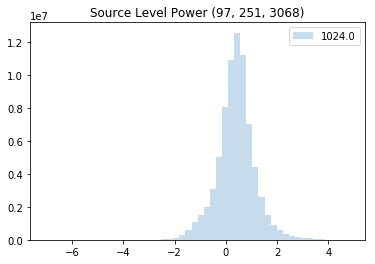

In [10]:
%%time
winsize = 500
stepsize = 250
samplerate = metadata['samplerate']

power = mne.time_frequency.stft(rawdata, wsize=winsize, tstep=stepsize)
freqs = mne.time_frequency.stftfreq(wsize=winsize, sfreq=samplerate)
power = np.log10(np.abs(power))
print(winsize)
print(stepsize)
print(power.shape)

plt.figure()
ax = sns.distplot(power.ravel(), kde=False, hist_kws={'alpha':0.25}, label='real'+str(samplerate))
ax.set_title('Source Level Power {}'.format(power.shape))
ax.legend()

print(max(power.ravel()))
print(min(power.ravel()))

freqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, samplerate//2],
}
power_binned = binfreqvalues(power, freqs, freqbands)

print(power_binned.shape)

plt.figure()
for i in range(len(freqbands)):
    label = sorted(freqbands.keys())[i]
    print(label)
    sns.distplot(power_binned[:,i,:].ravel(), kde=False, label='real'+label)
plt.legend()

Number of frequencies: 251
Number of time steps: 60
500
250
(137, 251, 60)
2.8682162750204996
-5.505474071017028
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 500.0])
(137, 4, 60)
alpha
beta
gamma
high
CPU times: user 797 ms, sys: 21.5 ms, total: 818 ms
Wall time: 819 ms


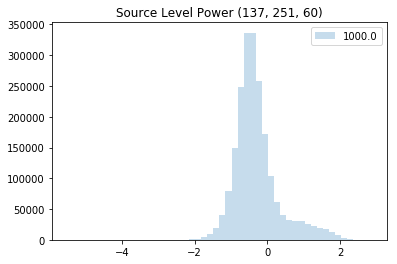

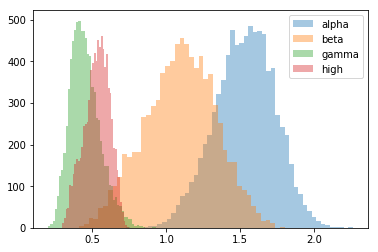

In [16]:
%%time
winsize = 500
stepsize = 250
samplerate = metadata['samplerate']

power = mne.time_frequency.stft(seegts, wsize=winsize, tstep=stepsize)
freqs = mne.time_frequency.stftfreq(wsize=winsize, sfreq=samplerate)
power = np.log10(np.abs(power))
print(winsize)
print(stepsize)
print(power.shape)

plt.figure()
ax = sns.distplot(power.ravel(), kde=False, hist_kws={'alpha':0.25}, label='sim'+str(samplerate))
ax.set_title('Source Level Power {}'.format(power.shape))
ax.legend()

print(max(power.ravel()))
print(min(power.ravel()))

freqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, samplerate//2],
}
power_binned = binfreqvalues(power, freqs, freqbands)

print(power_binned.shape)

plt.figure()
for i in range(len(freqbands)):
    label = sorted(freqbands.keys())[i]
    print(label)
    sns.distplot(power_binned[:,i,:].ravel(), kde=False, label='sim'+label)
plt.legend()

# Plot Them Together

Number of frequencies: 251
Number of time steps: 3068
Number of frequencies: 251
Number of time steps: 60
CPU times: user 2min 59s, sys: 1min 58s, total: 4min 57s
Wall time: 5min 15s


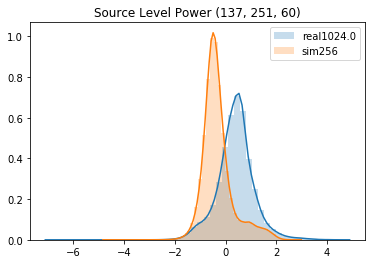

In [8]:
%%time
winsize = 500
stepsize = 250
samplerate = metadata['samplerate']

power = mne.time_frequency.stft(rawdata, wsize=winsize, tstep=stepsize)
freqs = mne.time_frequency.stftfreq(wsize=winsize, sfreq=samplerate)
power = np.log10(np.abs(power))

plt.figure()
ax = sns.distplot(power.ravel(), kde=True, hist_kws={'alpha':0.25}, label='real'+str(samplerate))
ax.set_title('Source Level Power {}'.format(power.shape))
ax.legend()

winsize = 500
stepsize = 250
samplerate = 256
power = mne.time_frequency.stft(seegts, wsize=winsize, tstep=stepsize)
freqs = mne.time_frequency.stftfreq(wsize=winsize, sfreq=samplerate)
power = np.log10(np.abs(power))

ax = sns.distplot(power.ravel(), kde=True, hist_kws={'alpha':0.25}, label='sim'+str(samplerate))
ax.set_title('Source Level Power {}'.format(power.shape))
ax.legend()

Number of frequencies: 251
Number of time steps: 3068
Number of frequencies: 251
Number of time steps: 60
CPU times: user 3min 15s, sys: 2min 11s, total: 5min 26s
Wall time: 5min 37s


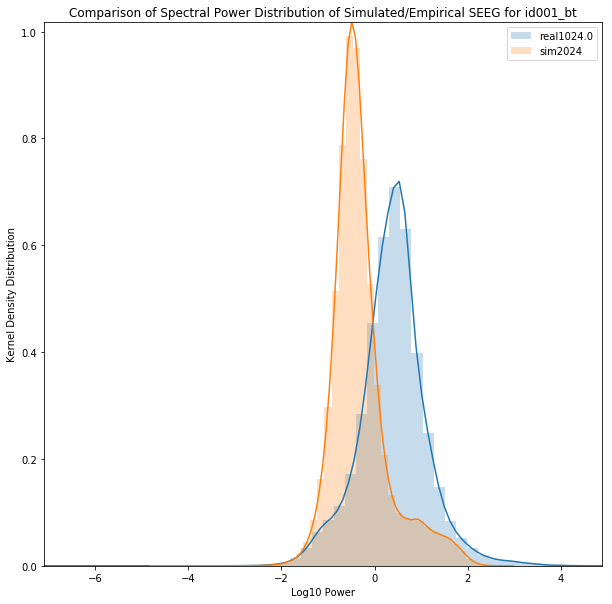

In [22]:
%%time
winsize = 500
stepsize = 250
samplerate = metadata['samplerate']

power = mne.time_frequency.stft(rawdata, wsize=winsize, tstep=stepsize)
freqs = mne.time_frequency.stftfreq(wsize=winsize, sfreq=samplerate)
realpower = np.log10(np.abs(power))

plt.figure(figsize=(10,10))
ax = sns.distplot(realpower.ravel(), kde=True, hist_kws={'alpha':0.25}, label='real'+str(samplerate))
ax.set_title('Source Level Power {}'.format(realpower.shape))
ax.legend()

winsize = 500
stepsize = 250
samplerate = 2024
power = mne.time_frequency.stft(seegts, wsize=winsize, tstep=stepsize)
freqs = mne.time_frequency.stftfreq(wsize=winsize, sfreq=samplerate)
power = np.log10(np.abs(power))

ax = sns.distplot(power.ravel(), kde=True, hist_kws={'alpha':0.25}, label='sim'+str(samplerate))
ax.set_xlabel('Log10 Power')
ax.set_ylabel('Kernel Density Distribution')
ax.set_title('Comparison of Spectral Power Distribution of Simulated/Empirical SEEG for {}'.format(patient))
ax.autoscale(tight=True)
ax.legend()

figdir = os.path.join('/Users/adam2392/Documents/figures/raw_freq_analysis/')
figfilename = os.path.join(figdir, '{}_psd_distrib_comparison_srate{}.pdf'.format(patient, samplerate))
ax.autoscale(tight=True)
plt.savefig(figfilename)

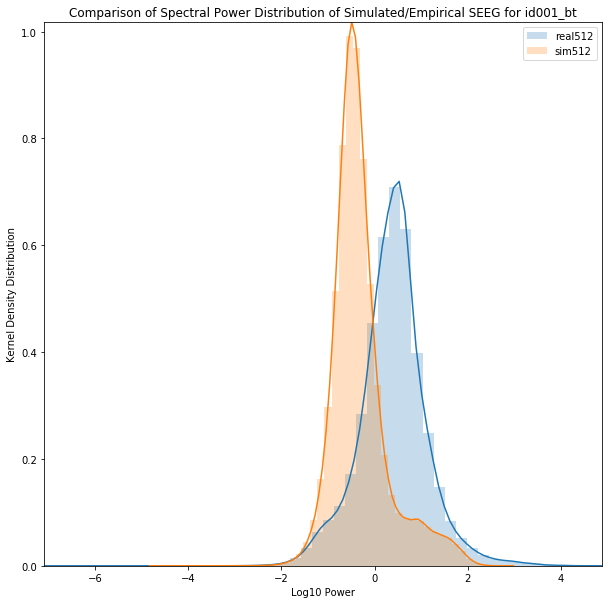

In [20]:
plt.figure(figsize=(10,10))
ax = sns.distplot(realpower.ravel(), kde=True, hist_kws={'alpha':0.25}, label='real'+str(samplerate))
ax.set_title('Source Level Power {}'.format(realpower.shape))
ax = sns.distplot(power.ravel(), kde=True, hist_kws={'alpha':0.25}, label='sim'+str(samplerate))
ax.set_xlabel('Log10 Power')
ax.set_ylabel('Kernel Density Distribution')
ax.set_title('Comparison of Spectral Power Distribution of Simulated/Empirical SEEG for {}'.format(patient))
ax.legend()

figdir = os.path.join('/Users/adam2392/Documents/figures/raw_freq_analysis/')
figfilename = os.path.join(figdir, '{}_psd_distrib_comparison.pdf'.format(patient))

ax.autoscale(tight=True)
plt.savefig(figfilename)

Number of frequencies: 251
Number of time steps: 3068
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 512.0])
Number of frequencies: 251
Number of time steps: 60
('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 128])
alpha
beta
gamma
high
alpha
beta
gamma
high
CPU times: user 5.72 s, sys: 1.28 s, total: 6.99 s
Wall time: 7 s


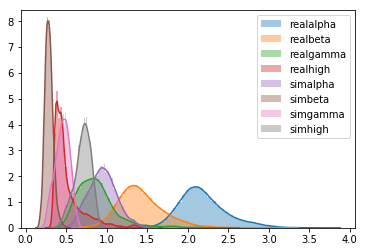

In [11]:
%%time
winsize = 500
stepsize = 250
samplerate = metadata['samplerate']
power = mne.time_frequency.stft(rawdata, wsize=winsize, tstep=stepsize)
freqs = mne.time_frequency.stftfreq(wsize=winsize, sfreq=samplerate)
realpower = np.log10(np.abs(power))

freqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, samplerate//2],
}
realpower_binned = binfreqvalues(realpower, freqs, freqbands)

winsize = 500
stepsize = 250
samplerate = 256
power = mne.time_frequency.stft(seegts, wsize=winsize, tstep=stepsize)
freqs = mne.time_frequency.stftfreq(wsize=winsize, sfreq=samplerate)
simpower = np.log10(np.abs(power))

freqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, samplerate//2],
}
simpower_binned = binfreqvalues(simpower, freqs, freqbands)


plt.figure()
for i in range(len(freqbands)):
    label = sorted(freqbands.keys())[i]
    print(label)
    sns.distplot(realpower_binned[:,i,:].ravel(), kde=True, label='real'+label)

for i in range(len(freqbands)):
    label = sorted(freqbands.keys())[i]
    print(label)
    sns.distplot(simpower_binned[:,i,:].ravel(), kde=True, label='sim'+label)
plt.legend()